<h1 style = "color: skyblue; font-family: Arial; font-size: 50 px; text-align: center;">Bitcoin Price Trend prediction using Machine Learning </h1>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_ta as ta

import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from datetime import datetime


<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px">Data Collection</h2>

In [2]:
ticker = 'BTC-USD'
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download(ticker, start_date, end_date)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


In [3]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-28,61612.804688,62126.097656,59985.402344,60320.136719,60320.136719,24952866877
2024-06-29,60319.875000,61097.621094,60300.964844,60887.378906,60887.378906,12652903396
2024-06-30,60888.445312,62892.828125,60632.949219,62678.292969,62678.292969,17333226409
2024-07-01,62673.605469,63777.226562,62495.511719,62851.980469,62851.980469,25468379421
2024-07-02,62844.410156,63203.359375,61752.746094,62029.015625,62029.015625,20151616992


In [4]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
data.shape

(1645, 6)

In [6]:
fig = go.Figure(data=[go.Candlestick(
    x=data.index,
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close']
    )])

fig.update_layout(
    title= f'{ticker} Price Data',
    yaxis_title= f'{ticker} Price USD ($)',
    xaxis_title= 'Date'
   # margin = dict(l=20, r=20, t=20, b=20)
)

fig.show()

<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px">Feature Engineering</h2>

In [7]:
# Imporve the dataset with technical indicators
data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'], length=20)
data['MA40'] = ta.sma(data['Close'], length=40)
data['MA80'] = ta.sma(data['Close'], length=80)
data['MA160'] = ta.sma(data['Close'], length=160)
data['EMA_12'] = ta.ema(data['Close'], length=12)
data['RSI'] = ta.rsi(data['Close'], length=14)
macd = ta.macd(data['Close'], fast=12, slow=26, signal=9)
data['MACD'] = macd['MACD_12_26_9']
data['MACD_Signal'] = macd['MACDs_12_26_9']
bollinger = ta.bbands(data['Close'], length=20, std=2)
data['Bollinger_Upper'] = bollinger['BBU_20_2.0']
data['Bollinger_Lower'] = bollinger['BBL_20_2.0']

# Create the target set
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

# Drop rows with NaN values after calculating indicators
data.dropna(inplace=True)

# Visualize data
data.head()

,Open,High,Low,Close,Adj Close,Volume,ATR,MA40,MA80,MA160,EMA_12,RSI,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Lower,Target
Date,,,,,,,,,,,,,,,,,
2020-06-08,9760.063477,9782.306641,9675.885742,9771.489258,9771.489258,21486346312,361.275640,9345.505981,8149.530878,8339.098956,9630.521929,56.728476,218.960031,228.100005,10147.925758,8736.105199,1
2020-06-09,9774.360352,9836.369141,9664.719727,9795.700195,9795.700195,23717842783,351.794329,9373.934644,8194.663800,8355.320993,9655.933970,57.098627,215.917384,225.663481,10177.643830,8733.659002,1
2020-06-10,9794.119141,9908.896484,9728.291016,9870.094727,9870.094727,25706567601,343.234886,9399.067847,8245.161798,8373.349896,9688.881779,58.279597,217.007552,223.932295,10217.184613,8772.951520,0
2020-06-11,9870.078125,9938.297852,9263.069336,9321.781250,9321.781250,30247143440,359.834567,9407.397461,8281.480127,8385.705502,9632.404775,47.829185,171.648546,213.475545,10214.582886,8789.473657,1
2020-06-12,9320.690430,9540.465820,9285.851562,9480.843750,9480.843750,22610564515,354.573552,9421.981836,8315.805627,8398.644171,9609.087694,50.596739,146.843501,200.149137,10215.568193,8815.644014,0


<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px">Split and Normalize the Data</h2>

In [8]:
# Prepare features and target
features = ['ATR','MA40','MA80','MA160','EMA_12', 'RSI', 'MACD', 'MACD_Signal', 'Bollinger_Upper', 'Bollinger_Lower', 'Volume']
X = data[features]
y = data['Target']


# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Split the features and target to training and testing sets
train_size = int(len(scaled_data)*0.8)
X_train, X_test = scaled_data[:train_size], scaled_data[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px">Model Training and Evaluation</h2>

In [9]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

Random Forest Performance:
Accuracy: 0.5100671140939598
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.70      0.57       140
           1       0.56      0.34      0.43       158

    accuracy                           0.51       298
   macro avg       0.52      0.52      0.50       298
weighted avg       0.53      0.51      0.49       298

Confusion Matrix:
[[ 98  42]
 [104  54]]


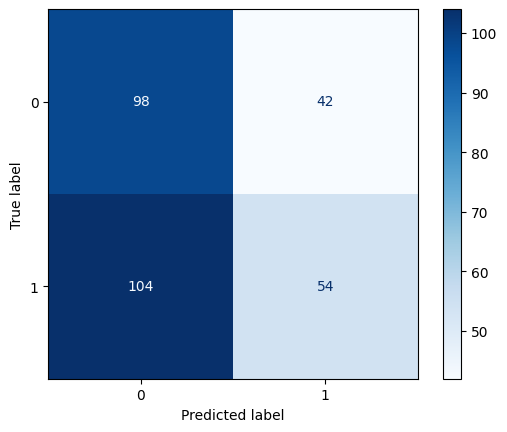

In [10]:
# Classifier 1: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print('Random Forest Performance:')
evaluate_model(rf_model, X_test, y_test)


Logistic Regression Performance:
Accuracy: 0.4697986577181208
Classification Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       140
           1       0.00      0.00      0.00       158

    accuracy                           0.47       298
   macro avg       0.23      0.50      0.32       298
weighted avg       0.22      0.47      0.30       298

Confusion Matrix:
[[140   0]
 [158   0]]


C:\Users\Nkamanyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Nkamanyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Nkamanyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

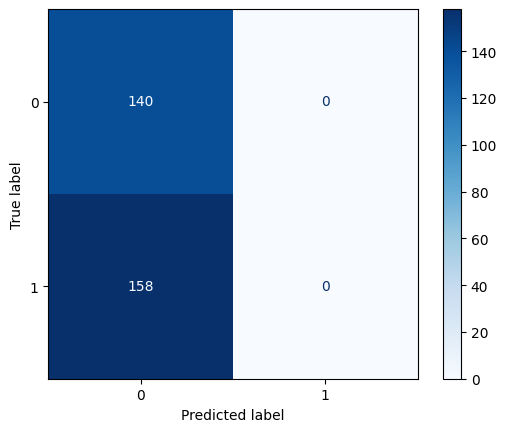

In [11]:
# Classifier 2: Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
print('\nLogistic Regression Performance:')
evaluate_model(lr_model, X_test, y_test)


Gradient Boosting Performance:
Accuracy: 0.49328859060402686
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.86      0.61       140
           1       0.57      0.17      0.26       158

    accuracy                           0.49       298
   macro avg       0.53      0.51      0.44       298
weighted avg       0.53      0.49      0.43       298

Confusion Matrix:
[[120  20]
 [131  27]]


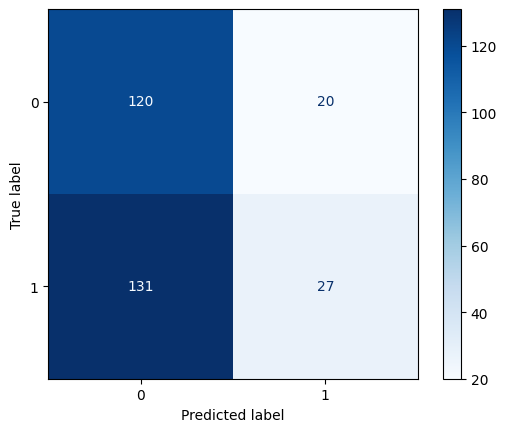

In [12]:
# Classifier 3: Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
print('\nGradient Boosting Performance:')
evaluate_model(gb_model, X_test, y_test)

In [13]:
# Classifier 4: Neural Network
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype("int32")

#print('\nNeural Network Performance:')
#print(f'Accuracy: {accuracy_score(y_test, y_pred_nn)}')
#print('Classification Report:')
#print(classification_report(y_test, y_pred_nn))
#print('Confusion Matrix:')
#print(confusion_matrix(y_test, y_pred_nn))

C:\Users\Nkamanyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4781 - loss: 0.7078
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5410 - loss: 0.6922
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4860 - loss: 0.6945
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5259 - loss: 0.6874
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5471 - loss: 0.6866
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5407 - loss: 0.6845
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5723 - loss: 0.6855
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5678 - loss: 0.6849
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5542 - loss: 0.6830
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5708 - loss: 0.6775
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5557 - loss: 0.6861
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [14]:
print('\nNeural Network Performance:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_nn)}')
print('Classification Report:')
print(classification_report(y_test, y_pred_nn))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_nn))


Neural Network Performance:
Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.85      0.61       140
           1       0.59      0.19      0.29       158

    accuracy                           0.50       298
   macro avg       0.54      0.52      0.45       298
weighted avg       0.54      0.50      0.44       298

Confusion Matrix:
[[119  21]
 [128  30]]


XGBoost Performance:
Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.79      0.60       140
           1       0.57      0.25      0.34       158

    accuracy                           0.50       298
   macro avg       0.52      0.52      0.47       298
weighted avg       0.53      0.50      0.46       298

Confusion Matrix:
[[110  30]
 [119  39]]


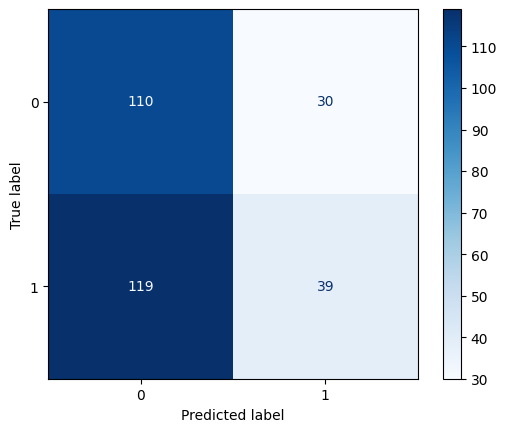

<Figure size 1000x600 with 0 Axes>

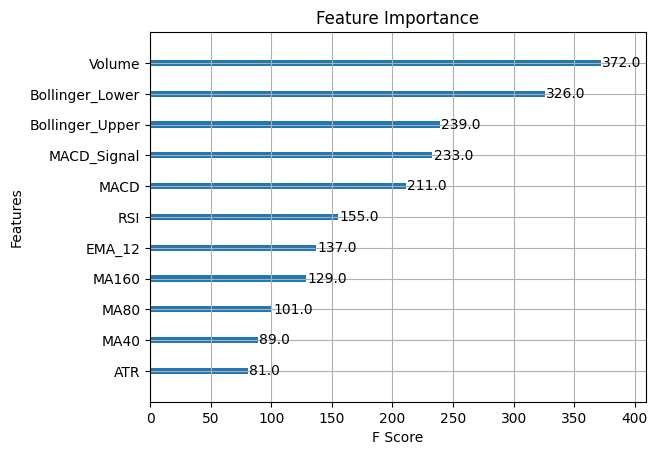

In [15]:
# Classifier: XGBoost
from matplotlib import pyplot
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
print('XGBoost Performance:')
evaluate_model(xgb_model, X_test, y_test)

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='weight', title='Feature Importance', xlabel='F Score', ylabel='Features')
ax = plt.gca()
ax.set_yticklabels(features)
plt.show()

In [16]:
# Backtesting with the best-performing model (Random Forest)
def backtest(data, model, scaler):
    data[features] = scaler.transform(data[features])
    data['Prediction'] = model.predict(data[features])
    data['Strategy_Return'] = data['Prediction'].shift(1) * data['Close'].pct_change()
    data['Market_Return'] = data['Close'].pct_change()
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()
    data['Cumulative_Market_Return'] = (1 + data['Market_Return']).cumprod()
    return data

backtest_results = backtest(data.copy(), rf_model, scaler)

C:\Users\Nkamanyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



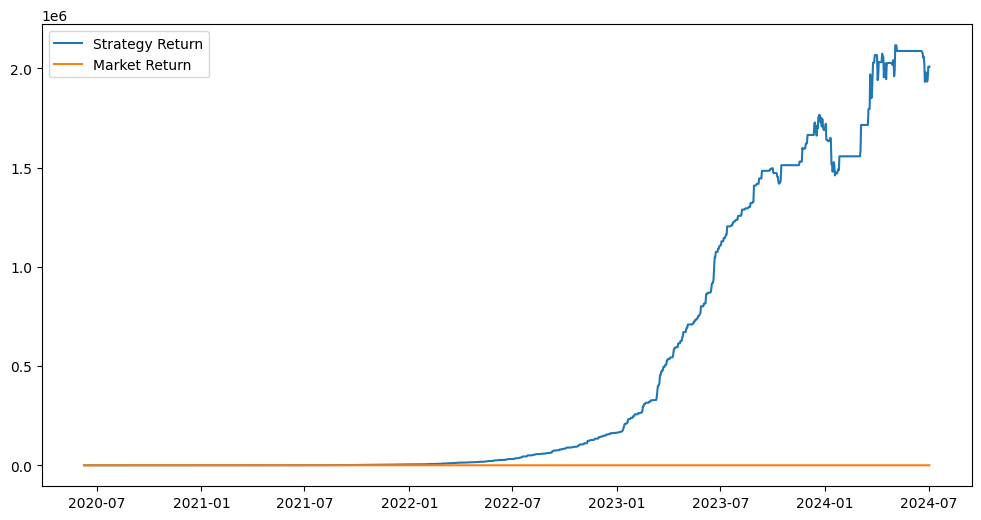

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(backtest_results.index, backtest_results['Cumulative_Strategy_Return'], label='Strategy Return')
plt.plot(backtest_results.index, backtest_results['Cumulative_Market_Return'], label='Market Return')
plt.legend()
plt.show()